# Advanced Machine Learning
## Deep Reinforcement Learning

&copy; Helena Aidos, 2024

### 3. Train the DQN agent

In this part of the project we will be performing **Deep Reinforcement Learning using JAX**, a library for array-oriented computation that enables high-performance machine learning research. Although Deep Reinforcement Learning can be computationally expensive and data-intensive, it is a powerful framework for solving problems where explicit programming or rule-based approaches fall short.

Similarly to Q-learning, DQN agents are defined by two functions: `act` and `update`.
- `act` function: implements an epsilon-greedy policy with respect to Q-values and the agent selects the action corresponding to the **maximum predicted Q-value** for a given state, with a set probability of acting randomly.
- `update` function: responsible for training the network: $$L(\theta)=E\left[ (r+(1-done) \times \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta))^2 \right],$$ where $\theta$ denotes the **parameters of the online network** and $\theta^-$ represents the **parameters of the target network**. Training is stabilized due to this separation of parameters.


#### 3.1 Creating a Gymnax environment: Mountain Car

We will be using `gymnax`as it is ideal for applications like meta-reinforcement learning. It provides precise functional control over environment settings, such as random seeds and hyperparameters, and enables parallelized rollouts across different configurations.

In [1]:
import gymnax

In [2]:
import jax

rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# create the Mountain Car environment
env, env_params = gymnax.make('MountainCarContinuous-v0')
# inspect default environment settings
env_params

EnvParams(max_steps_in_episode=999, min_action=-1.0, max_action=1.0, min_position=-1.2, max_position=0.6, max_speed=0.07, goal_position=0.45, goal_velocity=0.0, power=0.0015, gravity=0.0025)

In [3]:
# observation space dimensionality
env.observation_space(env_params).shape

(2,)

In [4]:
# action space dimensionality
env.action_space(env_params)

In [5]:
# alternatively, action space dimensionality
env.num_actions

1

In [6]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([-0.58275205,  0.        ], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), position=Array(-0.58275205, dtype=float32), velocity=Array(0., dtype=float32, weak_type=True)))

In [7]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

(Array([-0.5808441 ,  0.00190795], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), position=Array(-0.5808441, dtype=float32), velocity=Array(0.00190795, dtype=float32)),
 Array(-0.09559999, dtype=float32),
 Array(False, dtype=bool))

You can also simply use the environment with its default settings:

In [8]:
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action)

`gymnax` provides fully functional environment dynamics that can leverage the full power of JAX's function transformations. E.g. one common RL use-case the parallel rollout of multiple workers. Using a `vmap` across random seeds (one per worker) allows us to implement such a parallelization on a single machine:

In [9]:
vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))

num_envs = 8
vmap_keys = jax.random.split(rng, num_envs)

obs, state = vmap_reset(vmap_keys, env_params)
n_obs, n_state, reward, done, _ = vmap_step(vmap_keys, state, jax.numpy.zeros(num_envs), env_params)
print(n_obs.shape)

(8, 2)


#### 3.2. Implementing a DQN agent using RLinJAX

`RLinJAX` is a library of deep reinforcement learning algorithms which will allows to set up, train and evaluate deep RL agents. This library has implemented several deep reinforcement learning algorithms, from which we will be using: `dqn` (deep Q-network) and `sac` (soft actor-critic)


In [10]:
import time
from RLinJAX import *

In [11]:
jax.devices()

[CudaDevice(id=0)]

We will be setting up the training configuration using the following parameters:

In [42]:
CONFIGS = {"sac":{
                  #"num_envs": 10,
                  "buffer_size": 100_000,
                  "batch_size": 256,
                  "learning_rate": 0.00001,
                  "polyak": 0.95,
                  "num_epochs": 5,
                  "target_update_freq": 1000,
                  "total_timesteps": 500_000,
                  "eval_freq": 5000,
                  "gamma": 0.99,
                 }
          }

We will now create the algorithm instance for DQN in the MountainCar-v0 environment. 

In [43]:
algo_str = "sac"
env_str = "MountainCarContinuous-v0"

# `get_algo` is a convenient function to access algorithms easily
# `alg_cls.create` creates a frozen instance of the algorithm and populates it with default values
algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))

Let's look at the algorithm instance we have created:

In [44]:
algo.config

{'env': <gymnax.environments.classic_control.continuous_mountain_car.ContinuousMountainCar at 0x7f6e7b278070>,
 'env_params': {'max_steps_in_episode': 999,
  'min_action': -1.0,
  'max_action': 1.0,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.45,
  'goal_velocity': 0.0,
  'power': 0.0015,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 5000,
 'skip_initial_evaluation': False,
 'total_timesteps': 500000,
 'learning_rate': 1e-05,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'target_update_freq': 1000,
 'polyak': 0.95,
 'normalize_observations': False,
 'num_envs': 1,
 'buffer_size': 100000,
 'fill_buffer': 2048,
 'batch_size': 256,
 'actor': {'action_dim': 1,
  'action_range': (-1.0, 1.0),
  'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x7f6e7b278ee0>,
  'log_std_range': (-10, 2),
  'parent': None,
  'name':

In [45]:
# the `replace` method will be used to tune hyperparameters and variables
algo = algo.replace(gamma=0.95)
#algo = algo.replace(agent={"hidden_layer_sizes": (128, 128)})
print(f"New gamma: {algo.gamma}")

New gamma: 0.95


We will now be training the agent:

In [46]:
# set training seed and jit train function. Jit `algo.train` allows for faster execution
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train: the initial train_state holds currents environment step, network parameters and replay buffer contents
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 303.783 seconds (1645.91 steps/second).


In [47]:
print('Tuple size:', len(evaluation))
print('Episodic lengths and episodic returns shape:', evaluation[0].shape)
print(f"{algo.total_timesteps} / {algo.eval_freq} + 1 = {(algo.total_timesteps/algo.eval_freq+1)}")

Tuple size: 2
Episodic lengths and episodic returns shape: (101, 128)
500000 / 5000 + 1 = 101.0


In [48]:
evaluation

(Array([[999, 999, 999, ..., 999, 999, 999],
        [999, 999, 999, ..., 999, 999, 999],
        [999, 999, 999, ..., 999, 999, 999],
        ...,
        [999, 999, 999, ..., 999, 999, 999],
        [999, 999, 999, ..., 999, 999, 999],
        [999, 999, 999, ..., 999, 999, 999]], dtype=int32, weak_type=True),
 Array([[-33.167015  , -35.204037  , -35.77672   , ..., -34.242092  ,
         -34.223183  , -35.20155   ],
        [-32.723927  , -33.010242  , -34.431408  , ..., -33.415886  ,
         -35.3112    , -33.461857  ],
        [-32.764477  , -32.403637  , -32.302296  , ..., -32.26782   ,
         -32.626778  , -32.680046  ],
        ...,
        [ -0.7726413 ,  -0.91806465,  -0.8391309 , ...,  -0.78922755,
          -0.7936553 ,  -0.81282   ],
        [ -0.80346894,  -0.7910302 ,  -0.82318306, ...,  -0.8074169 ,
          -0.76878333,  -0.83203906],
        [ -0.75048125,  -0.84735686,  -0.77883136, ...,  -0.8006926 ,
          -0.8103955 ,  -0.860427  ]], dtype=float32))

We will now be plotting the learning curve.

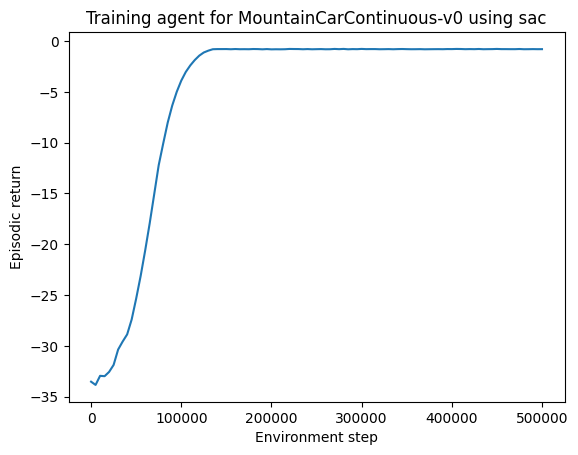

In [49]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, algo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.show()

Next, we will be looking at the `train_state`, to see what the algorithm produced.

In [50]:
jax.tree_util.tree_map(lambda x: x.shape, train_state).__dict__

{'rng': (2,),
 'env_state': EnvState(time=(1,), position=(1,), velocity=(1,)),
 'last_obs': (1, 2),
 'global_step': (),
 'last_done': (1,),
 'actor_ts': TrainState(step=(), apply_fn=(), params={'params': {'action_log_std': {'bias': (1,), 'kernel': (64, 1)}, 'action_mean': {'bias': (1,), 'kernel': (64, 1)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f6e7b115ea0>, update=<function chain.<locals>.update_fn at 0x7f6e7b116710>), opt_state=(ScaleByAdamState(count=(), mu={'params': {'action_log_std': {'bias': (1,), 'kernel': (64, 1)}, 'action_mean': {'bias': (1,), 'kernel': (64, 1)}, 'features': {'Dense_0': {'bias': (64,), 'kernel': (2, 64)}, 'Dense_1': {'bias': (64,), 'kernel': (64, 64)}}}}, nu={'params': {'action_log_std': {'bias': (1,), 'kernel': (64, 1)}, 'action_mean': {'bias': (1,), 'kernel': (64, 1)}, 'features': {'Dense_0': {'bias': (64,), 

`RLinJAX` allows for the use of the function `evaluate` to quickly and parallelly evaluate policies

In [51]:
# Algorithms return an agent's policy parameters in its train state. 
policy = algo.make_act(train_state)
policy = jax.jit(policy)

In [52]:
from RLinJAX.evaluate import evaluate

num_seeds = 200  
env, params = gymnax.make(env_str)
max_steps = params.max_steps_in_episode

rng = jax.random.PRNGKey(0)

start = time.time()

# Evaluation time!
episode_lengths, episode_returns = evaluate(policy, rng, env, params, num_seeds, max_steps)

time_elapsed = time.time() - start

print(
    f"Evaluated {num_seeds} episodes "
    f"with a total of {jax.numpy.sum(episode_lengths)} environment steps "
    f"in {time_elapsed:g} seconds."
)

avg_return = jax.numpy.mean(episode_returns)
print(f"Average Episode Return: {avg_return}")

success_rate = jax.numpy.sum(jax.numpy.array(episode_returns) > -200) / num_seeds
print(f"Success Rate: {success_rate * 100:.2f}%")


Evaluated 200 episodes with a total of 199800 environment steps in 0.96017 seconds.
Average Episode Return: -0.7961447238922119
Success Rate: 100.00%


[Text(0.5, 1.0, 'Episode return')]

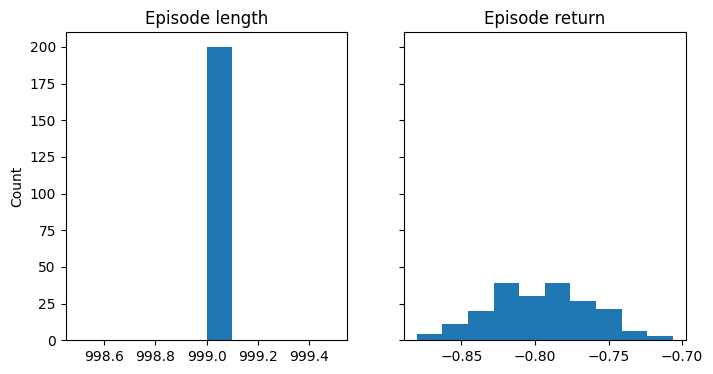

In [53]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharey="row")

axes[0].hist(episode_lengths, bins=10)
axes[0].set(title="Episode length", ylabel="Count")
axes[1].hist(episode_returns)
axes[1].set(title="Episode return")